# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import yaml
import warnings

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, f1_score, accuracy_score

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import joblib
import zipfile
#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [4]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int32  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int32  
 6   int             447136 non-null  int32  
 7   atm             447136 non-null  int32  
 8   col             447136 non-null  int32  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int32  
 12  circ            447136 non-null  int32  
 13  prof            447136 non-null  int32  
 14  plan            447136 non-null  int32  
 15  surf            447136 non-null  int32  
 16  infra           447136 non-null  int32  
 17  situ           

# Regroupement de modalités de 'grav' en 2 modalités : "indemnes" et "autres" 

In [5]:
# "tués (2) + blessés hospitalisés (3) + blessés légers (4)" => 0
df['grav'] = df['grav'].replace([2, 3, 4], 0)

# "indemnes (1)" => 1
df['grav'] = df['grav'].replace([1], 1)

df['grav'].unique()

array([0, 1])

# Séparation en train et test

Suppression des colonnes qui ne serviront pas pour la modélisation

In [6]:
df = df.drop(['an', 'jour', 'grav_rec', 'date', 'dep'], axis = 1)

Séparation des données de la cible

In [7]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
0    0.587267
1    0.412733
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chque modalité de la cible dans les jeux d'entraînement et de test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
0    0.587267
1    0.412733
Name: proportion, dtype: float64
grav
0    0.587267
1    0.412733
Name: proportion, dtype: float64


In [9]:
X_train.shape

(335352, 35)

# Création de train et test avec Oversampling et Undersampling

### Oversampling

Avec SMOTE

In [10]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
smo = SMOTENC(categorical_features = cat)
X_train_sm, y_train_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_train_sm).value_counts()))

Classes échantillon SMOTE : {1: 196941, 0: 196941}


Avec RandomOverSampler

In [11]:
rOs = RandomOverSampler()
X_train_ro, y_train_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_train_ro).value_counts()))

Classes échantillon oversampled : {1: 196941, 0: 196941}


### Undersampling

Avec RandomUnderSampler

In [12]:
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon undersampled : {0: 138411, 1: 138411}


Avec ClusterCentroids

In [13]:
cc = ClusterCentroids()
X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_train_cc).value_counts()))

Classes échantillon CC : {0: 138411, 1: 138411}


# Decision Tree

### Selection des variables

In [91]:
dt = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

In [92]:
print("Train acuracy :", np.round(dt.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.93 %
Test acuracy :  73.37 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50579,15068
1,14704,31433



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     65647
           1       0.68      0.68      0.68     46137

    accuracy                           0.73    111784
   macro avg       0.73      0.73      0.73    111784
weighted avg       0.73      0.73      0.73    111784



Calcul de l'importance de chaque variable

In [93]:
importances_dt = pd.DataFrame({'feature':X_train.columns,'importance':np.round(dt.feature_importances_,3)})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(38)

,importance
feature,
eq_ceinture,0.173
long,0.101
lat,0.100
age_usager,0.096
obs,0.060
heure,0.055
mois,0.045
col,0.045
place_rec,0.042


In [94]:
importances_dt.shape

(35, 1)

Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [96]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_dt), 1):
    liste_var = importances_dt.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    dt_2 = DecisionTreeClassifier(random_state = 42).fit(X_train_2, y_train)

    score = dt_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_dt = pd.DataFrame(dico)
y_pred_tableau_dt = y_pred_tableau_dt.sort_values(by = 'scores', ascending = False)
y_pred_tableau_dt.head(5)

,nombre_variable,scores
25,26,0.736107
31,32,0.735714
33,34,0.735311
26,27,0.735105
24,25,0.734944


In [97]:
nb_variable_dt = y_pred_tableau_dt.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_dt, 'variables')

La meilleur accuracy est obtenue avec 26.0 variables


In [98]:
meilleurs_variables_dt = importances_dt.index[0 : int(nb_variable_dt)]
meilleurs_variables_dt

Index(['eq_ceinture', 'long', 'lat', 'age_usager', 'obs', 'heure', 'mois',
       'col', 'place_rec', 'obsm', 'catv', 'agg', 'eq_indetermine', 'catr',
       'manv', 'sexe', 'prox_pt_choc', 'infra', 'lum', 'motor', 'int',
       'weekend', 'surf', 'plan', 'prof', 'circ'],
      dtype='object', name='feature')

In [99]:
liste_var = importances_dt.index[0 : int(nb_variable_dt)]
X_train_dt = X_train[liste_var]
X_test_dt = X_test[liste_var]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

In [100]:
print("Train acuracy :", np.round(dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.93 %
Test acuracy :  73.61 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50784,14863
1,14636,31501



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.77      0.77     65647
           1       0.68      0.68      0.68     46137

    accuracy                           0.74    111784
   macro avg       0.73      0.73      0.73    111784
weighted avg       0.74      0.74      0.74    111784



### Hyperparamétrage

In [44]:
liste_var_dt = ['eq_ceinture', 'long', 'lat', 'age_usager', 'obs', 'heure', 'mois',
       'col', 'place_rec', 'obsm', 'catv', 'agg', 'eq_indetermine', 'catr',
       'manv', 'sexe', 'prox_pt_choc', 'infra', 'lum', 'motor', 'int',
       'weekend', 'surf', 'plan', 'prof', 'circ']
X_train_dt = X_train[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

##### Avec class_weight = None

In [102]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None]
            }

In [103]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_weighted').fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.770334
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.755250
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.767188
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.755967
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.774673
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.771573
140  {'class_weight': None, 'criterion': 'entropy',...         0.777028
141  {'class_weight': None, 'criterion': 'entropy',...         0.771573
142  {'class_weight': None, 'criterion': 'entropy',...         0.777028
143  {'class_weight': None, 'criterion': 'entropy',...         0.771573

[144 rows x 2 columns]


In [104]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.779272012218339


In [105]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 79.73 %
Test acuracy :  77.79 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53089,12558
1,12281,33856



Rapport de classification :
               precision    recall  f1-score   support

           0       0.81      0.81      0.81     65647
           1       0.73      0.73      0.73     46137

    accuracy                           0.78    111784
   macro avg       0.77      0.77      0.77    111784
weighted avg       0.78      0.78      0.78    111784



Recherche du meilleur max_depth

In [45]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None]
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [46]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7734984435837171


In [47]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 79.24 %
Test acuracy :  78.24 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52429,13218
1,11109,35028



Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.80      0.81     65647
           1       0.73      0.76      0.74     46137

    accuracy                           0.78    111784
   macro avg       0.78      0.78      0.78    111784
weighted avg       0.78      0.78      0.78    111784



##### Avec class_weight = 'balanced'

In [106]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced'],
            }

In [107]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_weighted').fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': 'balanced', 'criterion': 'gin...         0.767475
1    {'class_weight': 'balanced', 'criterion': 'gin...         0.751030
2    {'class_weight': 'balanced', 'criterion': 'gin...         0.763573
3    {'class_weight': 'balanced', 'criterion': 'gin...         0.748678
4    {'class_weight': 'balanced', 'criterion': 'gin...         0.765960
..                                                 ...              ...
139  {'class_weight': 'balanced', 'criterion': 'ent...         0.766278
140  {'class_weight': 'balanced', 'criterion': 'ent...         0.777027
141  {'class_weight': 'balanced', 'criterion': 'ent...         0.766278
142  {'class_weight': 'balanced', 'criterion': 'ent...         0.777027
143  {'class_weight': 'balanced', 'criterion': 'ent...         0.766278

[144 rows x 2 columns]


In [108]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7772149566046036


In [109]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 79.78 %
Test acuracy :  78.07 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49323,16324
1,8373,37764



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.75      0.80     65647
           1       0.70      0.82      0.75     46137

    accuracy                           0.78    111784
   macro avg       0.78      0.78      0.78    111784
weighted avg       0.79      0.78      0.78    111784



Sélection du meilleur max_depth

In [103]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22, 26, 26],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced'],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [104]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7731146265643473


In [105]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 79.63 %
Test acuracy :  77.91 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49323,16324
1,8373,37764



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.75      0.80     65647
           1       0.70      0.82      0.75     46137

    accuracy                           0.78    111784
   macro avg       0.78      0.78      0.78    111784
weighted avg       0.79      0.78      0.78    111784



##### Recherche du meilleur class_weight

In [40]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:6, 1:7}]
            }

In [41]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_weighted').fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': {0: 6, 1: 7}, 'criterion': 'g...         0.787411
1    {'class_weight': {0: 6, 1: 7}, 'criterion': 'g...         0.783645
2    {'class_weight': {0: 6, 1: 7}, 'criterion': 'g...         0.787373
3    {'class_weight': {0: 6, 1: 7}, 'criterion': 'g...         0.783795
4    {'class_weight': {0: 6, 1: 7}, 'criterion': 'g...         0.787359
..                                                 ...              ...
139  {'class_weight': {0: 6, 1: 7}, 'criterion': 'e...         0.785220
140  {'class_weight': {0: 6, 1: 7}, 'criterion': 'e...         0.781018
141  {'class_weight': {0: 6, 1: 7}, 'criterion': 'e...         0.785220
142  {'class_weight': {0: 6, 1: 7}, 'criterion': 'e...         0.781018
143  {'class_weight': {0: 6, 1: 7}, 'criterion': 'e...         0.785220

[144 rows x 2 columns]


In [42]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': {0: 6, 1: 7}, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7881891576043352


In [43]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 79.46 %
Test acuracy :  79.12 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51475,14172
1,9307,36830



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.78      0.81     65647
           1       0.72      0.80      0.76     46137

    accuracy                           0.79    111784
   macro avg       0.78      0.79      0.79    111784
weighted avg       0.80      0.79      0.79    111784



Sélection du meilleur max_depth

In [106]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [10], 
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:6, 1:7}]
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [107]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': {0: 6, 1: 7}, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7835284453423581


In [108]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 79.34 %
Test acuracy :  79.0 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51475,14172
1,9307,36830



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.78      0.81     65647
           1       0.72      0.80      0.76     46137

    accuracy                           0.79    111784
   macro avg       0.78      0.79      0.79    111784
weighted avg       0.80      0.79      0.79    111784



##### Avec SMOTE

In [110]:
liste_var_dt = ['eq_ceinture', 'long', 'lat', 'age_usager', 'obs', 'heure', 'mois',
       'col', 'place_rec', 'obsm', 'catv', 'agg', 'eq_indetermine', 'catr',
       'manv', 'sexe', 'prox_pt_choc', 'infra', 'lum', 'motor', 'int',
       'weekend', 'surf', 'plan', 'prof', 'circ']
X_train_sm_dt = X_train_sm[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_sm_dt, y_train_sm)

In [119]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [120]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_weighted').fit(X_train_sm_dt, y_train_sm)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.779557
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.761701
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.770165
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.762357
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.780632
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.778609
140  {'class_weight': None, 'criterion': 'entropy',...         0.785907
141  {'class_weight': None, 'criterion': 'entropy',...         0.778609
142  {'class_weight': None, 'criterion': 'entropy',...         0.785907
143  {'class_weight': None, 'criterion': 'entropy',...         0.778609

[144 rows x 2 columns]


In [121]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7861332609353481


In [122]:
print("Train acuracy :", np.round(grid_dt.score(X_train_sm_dt, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 80.72 %
Test acuracy :  77.74 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50027,15620
1,9434,36703



Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.76      0.80     65647
           1       0.70      0.80      0.75     46137

    accuracy                           0.78    111784
   macro avg       0.77      0.78      0.77    111784
weighted avg       0.78      0.78      0.78    111784



Sélection du meilleur max_depth

In [111]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }   

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_sm_dt, y_train_sm)

In [112]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7884041233707846


In [113]:
y_train_pred = grid_dt_2.predict(X_train_sm_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 80.33 %
Test acuracy :  77.65 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49542,16105
1,8884,37253



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.75      0.80     65647
           1       0.70      0.81      0.75     46137

    accuracy                           0.78    111784
   macro avg       0.77      0.78      0.77    111784
weighted avg       0.79      0.78      0.78    111784



##### Avec RandomOverSampler

In [114]:
liste_var_dt = ['eq_ceinture', 'long', 'lat', 'age_usager', 'obs', 'heure', 'mois',
       'col', 'place_rec', 'obsm', 'catv', 'agg', 'eq_indetermine', 'catr',
       'manv', 'sexe', 'prox_pt_choc', 'infra', 'lum', 'motor', 'int',
       'weekend', 'surf', 'plan', 'prof', 'circ']
X_train_ro_dt = X_train_ro[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ro_dt, y_train_ro)

In [115]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [116]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_weighted').fit(X_train_ro_dt, y_train_ro)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.775344
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.758810
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.772679
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.759786
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.772622
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.776668
140  {'class_weight': None, 'criterion': 'entropy',...         0.783474
141  {'class_weight': None, 'criterion': 'entropy',...         0.776668
142  {'class_weight': None, 'criterion': 'entropy',...         0.783474
143  {'class_weight': None, 'criterion': 'entropy',...         0.776668

[144 rows x 2 columns]


In [117]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8032388747505547


In [118]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ro_dt, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.94 %
Test acuracy :  73.47 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50916,14731
1,14913,31224



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.78      0.77     65647
           1       0.68      0.68      0.68     46137

    accuracy                           0.73    111784
   macro avg       0.73      0.73      0.73    111784
weighted avg       0.73      0.73      0.73    111784



Sélection du meilleur max_depth

In [123]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [20,  30, 40, 50, 60, 70],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ro_dt, y_train_ro)

In [124]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8038590091347381


In [125]:
y_train_pred = grid_dt_2.predict(X_train_ro_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.38 %
Test acuracy :  73.77 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50928,14719
1,14602,31535



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.78      0.78     65647
           1       0.68      0.68      0.68     46137

    accuracy                           0.74    111784
   macro avg       0.73      0.73      0.73    111784
weighted avg       0.74      0.74      0.74    111784



##### Avec RandomUnderSampler

In [56]:
liste_var_dt = ['eq_ceinture', 'long', 'lat', 'age_usager', 'obs', 'heure', 'mois',
       'col', 'place_rec', 'obsm', 'catv', 'agg', 'eq_indetermine', 'catr',
       'manv', 'sexe', 'prox_pt_choc', 'infra', 'lum', 'motor', 'int',
       'weekend', 'surf', 'plan', 'prof', 'circ']
X_train_ru_dt = X_train_ru[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ru_dt, y_train_ru)

In [ ]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [ ]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_weighted').fit(X_train_ru_dt, y_train_ru)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.777659
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.757519
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.778038
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.758339
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.771828
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.767649
140  {'class_weight': None, 'criterion': 'entropy',...         0.776925
141  {'class_weight': None, 'criterion': 'entropy',...         0.767649
142  {'class_weight': None, 'criterion': 'entropy',...         0.776925
143  {'class_weight': None, 'criterion': 'entropy',...         0.767649

[144 rows x 2 columns]


In [ ]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7794647832151702


In [ ]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ru_dt, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 80.04 %
Test acuracy :  77.5 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49414,16233
1,8915,37222



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.75      0.80     65647
           1       0.70      0.81      0.75     46137

    accuracy                           0.78    111784
   macro avg       0.77      0.78      0.77    111784
weighted avg       0.78      0.78      0.78    111784



Recherche du meilleur max_depth

In [126]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ru_dt, y_train_ru)

In [127]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7805330835529866


In [128]:
y_train_pred = grid_dt_2.predict(X_train_ru_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 79.84 %
Test acuracy :  77.82 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49688,15959
1,8835,37302



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.76      0.80     65647
           1       0.70      0.81      0.75     46137

    accuracy                           0.78    111784
   macro avg       0.77      0.78      0.78    111784
weighted avg       0.79      0.78      0.78    111784



##### Avec ClusterCentroids

In [60]:
liste_var_dt = ['eq_ceinture', 'long', 'lat', 'age_usager', 'obs', 'heure', 'mois',
       'col', 'place_rec', 'obsm', 'catv', 'agg', 'eq_indetermine', 'catr',
       'manv', 'sexe', 'prox_pt_choc', 'infra', 'lum', 'motor', 'int',
       'weekend', 'surf', 'plan', 'prof', 'circ']
X_train_cc_dt = X_train_cc[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_cc_dt, y_train_cc)

In [ ]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [ ]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_weighted').fit(X_train_cc_dt, y_train_cc)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.774751
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.758744
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.775831
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.760142
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.775264
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.770231
140  {'class_weight': None, 'criterion': 'entropy',...         0.774826
141  {'class_weight': None, 'criterion': 'entropy',...         0.770231
142  {'class_weight': None, 'criterion': 'entropy',...         0.774826
143  {'class_weight': None, 'criterion': 'entropy',...         0.770231

[144 rows x 2 columns]


In [ ]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 42, 'splitter': 'best'}
0.7768674655071157


In [ ]:
print("Train acuracy :", np.round(grid_dt.score(X_train_cc_dt, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 78.02 %
Test acuracy :  76.65 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,47273,18374
1,7728,38409



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.72      0.78     65647
           1       0.68      0.83      0.75     46137

    accuracy                           0.77    111784
   macro avg       0.77      0.78      0.77    111784
weighted avg       0.78      0.77      0.77    111784



Recherche du meilleur max_depth

In [129]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['random'],
            'max_depth' : [2, 4, 6, 8, 10, 12],
            'min_samples_split' : [10], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_cc_dt, y_train_cc)

In [130]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 42, 'splitter': 'random'}
0.7638597024257681


In [131]:
y_train_pred = grid_dt_2.predict(X_train_cc_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 77.56 %
Test acuracy :  75.06 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,45820,19827
1,8054,38083



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.70      0.77     65647
           1       0.66      0.83      0.73     46137

    accuracy                           0.75    111784
   macro avg       0.75      0.76      0.75    111784
weighted avg       0.77      0.75      0.75    111784



# Random Forest

### Selection des variables

In [117]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

In [123]:
print("Train acuracy :", np.round(rf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.93 %
Test acuracy :  80.54 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54802,10845
1,10909,35228



Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.83      0.83     65647
           1       0.76      0.76      0.76     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.80      0.80    111784
weighted avg       0.81      0.81      0.81    111784



In [124]:
importances_rf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(38)

,importance
feature,
age_usager,0.089
eq_ceinture,0.088
lat,0.086
long,0.085
place_rec,0.060
heure,0.060
col,0.054
catv,0.049
obsm,0.049


Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [125]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_rf), 1):
    liste_var = importances_rf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    rf_2 = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = rf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_rf = pd.DataFrame(dico)
y_pred_tableau_rf = y_pred_tableau_rf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_rf.head(5)

,nombre_variable,scores
33,34,0.806081
32,33,0.805715
31,32,0.805643
28,29,0.805178
27,28,0.805017


In [126]:
nb_variable_rf = y_pred_tableau_rf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_rf, 'variables')

La meilleur accuracy est obtenue avec 34.0 variables


In [127]:
meilleurs_variables_rf = importances_rf.index[0 : int(nb_variable_rf)]
meilleurs_variables_rf

Index(['age_usager', 'eq_ceinture', 'lat', 'long', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'manv', 'motor', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'jour_chome', 'prof', 'circ', 'situ', 'surf',
       'int', 'plan', 'atm', 'eq_airbag', 'eq_gilet', 'eq_siege'],
      dtype='object', name='feature')

In [128]:
liste_var = importances_rf.index[0 : int(nb_variable_rf)]
X_train_rf = X_train[liste_var]
X_test_rf = X_test[liste_var]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

In [129]:
print("Train acuracy :", np.round(rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.93 %
Test acuracy :  80.61 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54749,10898
1,10779,35358



Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.83      0.83     65647
           1       0.76      0.77      0.77     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.80      0.80    111784
weighted avg       0.81      0.81      0.81    111784



### Hyperparamétrage

In [135]:
liste_var_rf = ['age_usager', 'eq_ceinture', 'lat', 'long', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'manv', 'motor', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'jour_chome', 'prof', 'circ', 'situ', 'surf',
       'int', 'plan', 'atm', 'eq_airbag', 'eq_gilet', 'eq_siege']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

##### Avec class_weight = None

In [138]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20, None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

In [139]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_weighted').fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.787532
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.787687
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.788021
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.787887
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.787887
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.802135
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.802135
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.799730
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.799730
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.799730

[108 rows x 2 columns]


In [140]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.805614465655401


In [141]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 87.95 %
Test acuracy :  80.86 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54027,11620
1,9827,36310



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.82      0.83     65647
           1       0.76      0.79      0.77     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.80      0.80    111784
weighted avg       0.81      0.81      0.81    111784



Recherche du meilleur max_depth

In [148]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
             'min_samples_split' : [10],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [149]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8005200472790083


In [150]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 91.91 %
Test acuracy :  80.97 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54439,11208
1,10068,36069



Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.83      0.84     65647
           1       0.76      0.78      0.77     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.81      0.81    111784



##### Avec class_weight = 'balanced'

In [22]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20, None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}    

In [23]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_weighted').fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': 'balanced...         0.769003
1    {'bootstrap': False, 'class_weight': 'balanced...         0.768992
2    {'bootstrap': False, 'class_weight': 'balanced...         0.768919
3    {'bootstrap': False, 'class_weight': 'balanced...         0.768647
4    {'bootstrap': False, 'class_weight': 'balanced...         0.768647
..                                                 ...              ...
139  {'bootstrap': True, 'class_weight': 'balanced'...         0.792383
140  {'bootstrap': True, 'class_weight': 'balanced'...         0.792383
141  {'bootstrap': True, 'class_weight': 'balanced'...         0.790117
142  {'bootstrap': True, 'class_weight': 'balanced'...         0.790117
143  {'bootstrap': True, 'class_weight': 'balanced'...         0.790117

[144 rows x 2 columns]


In [24]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.804781538464279


In [ ]:
print("Train acuracy :", np.round(grid_brf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 93.51 %
Test acuracy :  80.89 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52891,12756
1,8718,37419



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.81      0.83     65647
           1       0.75      0.81      0.78     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.81      0.81    111784



Recherche du meilleur max_depth

In [68]:
params_brf = {'n_estimators' : [100],
            'criterion' : ['entropy'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70],
            'min_samples_split' : [10], 
            'min_samples_leaf' : [1], 
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}   

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [69]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8000720970373288


In [70]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 93.51 %
Test acuracy :  80.81 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52940,12707
1,8748,37389



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.81      0.83     65647
           1       0.75      0.81      0.78     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.81      0.81    111784



##### Recherche du meilleur class_weight

In [ ]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20, None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:6, 1:7}]} 

In [140]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_weighted').fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': False, 'class_weight': {0: 6, 1:...         0.782679
1   {'bootstrap': False, 'class_weight': {0: 6, 1:...         0.804503
2   {'bootstrap': False, 'class_weight': {0: 6, 1:...         0.799780
3   {'bootstrap': False, 'class_weight': {0: 6, 1:...         0.781457
4   {'bootstrap': False, 'class_weight': {0: 6, 1:...         0.803987
5   {'bootstrap': False, 'class_weight': {0: 6, 1:...         0.800265
6   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.781759
7   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.804004
8   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.801787
9   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.781517
10  {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.803604
11  {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.802553


In [ ]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': {0: 6, 1: 7}, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8045025698838295


In [ ]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 90.22 %
Test acuracy :  80.76 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52529,13118
1,8507,37630



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.80      0.83     65647
           1       0.74      0.82      0.78     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.81      0.81    111784



Recherche du meilleur max_depth

In [151]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'bootstrap' : [False],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:6, 1:7}]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [152]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': {0: 6, 1: 7}, 'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8004227510193284


In [153]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 92.84 %
Test acuracy :  80.77 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53008,12639
1,8852,37285



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.81      0.83     65647
           1       0.75      0.81      0.78     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.81      0.81    111784



##### Avec SMOTE

In [74]:
liste_var_rf = ['age_usager', 'eq_ceinture', 'lat', 'long', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'manv', 'motor', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'jour_chome', 'prof', 'circ', 'situ', 'surf',
       'int', 'plan', 'atm', 'eq_airbag', 'eq_gilet', 'eq_siege']
X_train_sm_rf = X_train_sm[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_sm_rf, y_train_sm)

In [144]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20, None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

In [145]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_weighted').fit(X_train_sm_rf, y_train_sm)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.787714
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.787434
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.787460
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.787174
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.787174
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.811173
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.811173
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.806736
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.806736
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.806736

[108 rows x 2 columns]


In [146]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8239586038864439


In [147]:
print("Train acuracy :", np.round(grid_rf.score(X_train_sm_rf, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.94 %
Test acuracy :  80.32 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53150,12497
1,9590,36547



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.81      0.83     65647
           1       0.75      0.79      0.77     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.80      0.80    111784
weighted avg       0.81      0.80      0.80    111784



Recherche du meilleur max_depth

In [75]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_sm_rf, y_train_sm)

In [76]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8242747617658452


In [77]:
y_train_pred = grid_rf_2.predict(X_train_sm_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.94 %
Test acuracy :  80.16 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53087,12560
1,9620,36517



Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.81      0.83     65647
           1       0.74      0.79      0.77     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.80      0.80    111784
weighted avg       0.80      0.80      0.80    111784



##### Avec RandomOverSampler

In [78]:
liste_var_rf = ['age_usager', 'eq_ceinture', 'lat', 'long', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'manv', 'motor', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'jour_chome', 'prof', 'circ', 'situ', 'surf',
       'int', 'plan', 'atm', 'eq_airbag', 'eq_gilet', 'eq_siege']
X_train_ro_rf = X_train_ro[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ro_rf, y_train_ro)

In [149]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20, None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [150]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_weighted').fit(X_train_ro_rf, y_train_ro)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.784603
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.784182
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.783667
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.784250
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.784250
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.812844
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.812844
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.805754
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.805754
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.805754

[108 rows x 2 columns]


In [151]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8519933120646217


In [152]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ro_rf, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.94 %
Test acuracy :  80.27 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54849,10798
1,11237,34900



Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.84      0.83     65647
           1       0.76      0.76      0.76     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.80      0.80    111784
weighted avg       0.80      0.80      0.80    111784



Recherche du meilleur max_depth

In [154]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ro_rf, y_train_ro)

In [155]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8523240503985721


In [156]:
y_train_pred = grid_rf_2.predict(X_train_ro_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.94 %
Test acuracy :  80.32 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54910,10737
1,11267,34870



Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.84      0.83     65647
           1       0.76      0.76      0.76     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.80      0.80    111784
weighted avg       0.80      0.80      0.80    111784



##### Avec RandomUnderSampler

In [85]:
liste_var_rf = ['age_usager', 'eq_ceinture', 'lat', 'long', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'manv', 'motor', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'jour_chome', 'prof', 'circ', 'situ', 'surf',
       'int', 'plan', 'atm', 'eq_airbag', 'eq_gilet', 'eq_siege']
X_train_ru_rf = X_train_ru[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ru_rf, y_train_ru)

In [154]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20, None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [155]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_weighted').fit(X_train_ru_rf, y_train_ru)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.782945
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.782324
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.782079
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.782571
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.782571
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.800873
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.800873
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.798370
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.798370
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.798370

[108 rows x 2 columns]


In [156]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8046856751395506


In [157]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ru_rf, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 93.13 %
Test acuracy :  80.29 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50426,15221
1,6980,39157



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.77      0.82     65647
           1       0.72      0.85      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



Recherche du meilleur max_depth

In [86]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70],
             'min_samples_split' : [20],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ru_rf, y_train_ru)

In [87]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8049475700343638


In [88]:
y_train_pred = grid_rf_2.predict(X_train_ru_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 91.91 %
Test acuracy :  80.12 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50314,15333
1,6887,39250



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.77      0.82     65647
           1       0.72      0.85      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



##### Avec ClusterCentroids

In [89]:
liste_var_rf = ['age_usager', 'eq_ceinture', 'lat', 'long', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'manv', 'motor', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'jour_chome', 'prof', 'circ', 'situ', 'surf',
       'int', 'plan', 'atm', 'eq_airbag', 'eq_gilet', 'eq_siege']
X_train_cc_rf = X_train_cc[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_cc_rf, y_train_cc)

In [159]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20, None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [160]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_weighted').fit(X_train_cc_rf, y_train_cc)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.788473
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.788081
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.787976
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.787368
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.787368
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.804719
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.804719
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.801436
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.801436
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.801436

[108 rows x 2 columns]


In [161]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8105672001309291


In [162]:
print("Train acuracy :", np.round(grid_rf.score(X_train_cc_rf, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 98.82 %
Test acuracy :  78.63 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,48321,17326
1,6744,39393



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.74      0.80     65647
           1       0.69      0.85      0.77     46137

    accuracy                           0.78    111784
   macro avg       0.79      0.79      0.78    111784
weighted avg       0.80      0.78      0.79    111784



Recherche du meilleur max_depth

In [90]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70],
             'min_samples_split' : [10],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_cc_rf, y_train_cc)

In [91]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8105934541854275


In [92]:
y_train_pred = grid_rf_2.predict(X_train_cc_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 98.71 %
Test acuracy :  78.42 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,48281,17366
1,6759,39378



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.74      0.80     65647
           1       0.69      0.85      0.77     46137

    accuracy                           0.78    111784
   macro avg       0.79      0.79      0.78    111784
weighted avg       0.80      0.78      0.79    111784



# Balanced Random Forest

### Selection des variables

In [163]:
brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [164]:
print("Train acuracy :", np.round(brf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.05 %
Test acuracy :  80.13 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50722,14925
1,7284,38853



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.77      0.82     65647
           1       0.72      0.84      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



In [165]:
importances_brf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(brf.feature_importances_,3)})
importances_brf = importances_brf.sort_values('importance',ascending=False).set_index('feature')
importances_brf.head(38)

,importance
feature,
age_usager,0.087
lat,0.084
long,0.083
eq_ceinture,0.082
place_rec,0.066
heure,0.058
col,0.055
catv,0.051
obsm,0.048


In [166]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_brf), 1):
    liste_var = importances_brf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    brf_2 = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = brf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_brf = pd.DataFrame(dico)
y_pred_tableau_brf = y_pred_tableau_brf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_brf.head(5)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

,nombre_variable,scores
27,28,0.801582
29,30,0.801313
32,33,0.801286
33,34,0.801116
31,32,0.801081


In [167]:
nb_variable_brf = y_pred_tableau_brf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_brf, 'variables')

La meilleur accuracy est obtenue avec 28.0 variables


In [168]:
meilleurs_variables_brf = importances_brf.index[0 : int(nb_variable_brf)]
meilleurs_variables_brf

Index(['age_usager', 'lat', 'long', 'eq_ceinture', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'motor', 'manv', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'situ', 'jour_chome', 'circ', 'int', 'surf'],
      dtype='object', name='feature')

In [169]:
liste_var = importances_brf.index[0 : int(nb_variable_brf)]
X_train_brf = X_train[liste_var]
X_test_brf = X_test[liste_var]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [170]:
print("Train acuracy :", np.round(brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.0 %
Test acuracy :  80.16 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50924,14723
1,7457,38680



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.78      0.82     65647
           1       0.72      0.84      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



### Hyperparamétrage

In [93]:
liste_var_brf = ['age_usager', 'lat', 'long', 'eq_ceinture', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'motor', 'manv', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'situ', 'jour_chome', 'circ', 'int', 'surf']
X_train_brf = X_train[liste_var_brf]
X_test_brf = X_test[liste_var_brf]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

##### Avec class_weight = None

In [32]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20, None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]} 

In [33]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_weighted').fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': None, 'cri...         0.775654
1   {'bootstrap': True, 'class_weight': None, 'cri...         0.774512
2   {'bootstrap': True, 'class_weight': None, 'cri...         0.774734
3   {'bootstrap': True, 'class_weight': None, 'cri...         0.774662
4   {'bootstrap': True, 'class_weight': None, 'cri...         0.774662
5   {'bootstrap': True, 'class_weight': None, 'cri...         0.774662
6   {'bootstrap': True, 'class_weight': None, 'cri...         0.774346
7   {'bootstrap': True, 'class_weight': None, 'cri...         0.774346
8   {'bootstrap': True, 'class_weight': None, 'cri...         0.774346
9   {'bootstrap': True, 'class_weight': None, 'cri...         0.798183
10  {'bootstrap': True, 'class_weight': None, 'cri...         0.797469
11  {'bootstrap': True, 'class_weight': None, 'cri...         0.796467
12  {'bootstrap': True, 'class_weight': None, 'cri...         0.794108
13  {'

In [34]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.8009815636320978


In [35]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 96.8 %
Test acuracy :  80.47 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51685,13962
1,8018,38119



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.79      0.82     65647
           1       0.73      0.83      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



Recherche du meilleur max_depth

In [160]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['entropy'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]}  

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [161]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7968124230557251


In [162]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 94.14 %
Test acuracy :  80.31 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51334,14313
1,7694,38443



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.78      0.82     65647
           1       0.73      0.83      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



##### Avec class_weight = 'balanced'

In [36]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20, None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

In [37]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_weighted').fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': 'balanced'...         0.752789
1   {'bootstrap': True, 'class_weight': 'balanced'...         0.752762
2   {'bootstrap': True, 'class_weight': 'balanced'...         0.752332
3   {'bootstrap': True, 'class_weight': 'balanced'...         0.751989
4   {'bootstrap': True, 'class_weight': 'balanced'...         0.751989
5   {'bootstrap': True, 'class_weight': 'balanced'...         0.751989
6   {'bootstrap': True, 'class_weight': 'balanced'...         0.751736
7   {'bootstrap': True, 'class_weight': 'balanced'...         0.751736
8   {'bootstrap': True, 'class_weight': 'balanced'...         0.751736
9   {'bootstrap': True, 'class_weight': 'balanced'...         0.791051
10  {'bootstrap': True, 'class_weight': 'balanced'...         0.787954
11  {'bootstrap': True, 'class_weight': 'balanced'...         0.784692
12  {'bootstrap': True, 'class_weight': 'balanced'...         0.778956
13  {'

In [38]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.8015546882492377


In [39]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 96.9 %
Test acuracy :  80.51 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52064,13583
1,8338,37799



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.79      0.83     65647
           1       0.74      0.82      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.81    111784



Recherche du meilleur max_depth

In [97]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [98]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7972213625696309


In [99]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 96.91 %
Test acuracy :  80.41 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52120,13527
1,8366,37771



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.79      0.83     65647
           1       0.74      0.82      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.81    111784



##### Recherche du meilleur class_weight

In [28]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['entropy', 'gini'],
              'max_depth' : [10, 20, None],
              'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:6, 1:7}]}

In [29]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_weighted').fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.762711
1   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.762258
2   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.762260
3   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.762436
4   {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.762436
..                                                ...              ...
67  {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.785130
68  {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.785130
69  {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.782948
70  {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.782948
71  {'bootstrap': True, 'class_weight': {0: 6, 1: ...         0.782948

[72 rows x 2 columns]


In [30]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': {0: 6, 1: 7}, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.8017390104959283


In [31]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 96.89 %
Test acuracy :  80.44 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51831,13816
1,8192,37945



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.79      0.82     65647
           1       0.73      0.82      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



Recherche du meilleur max_depth

In [100]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:6, 1:7}]}

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [101]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': {0: 6, 1: 7}, 'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7973889779140877


In [102]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 96.88 %
Test acuracy :  80.31 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51832,13815
1,8195,37942



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.79      0.82     65647
           1       0.73      0.82      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



# Interprétation du meilleur modèle

### Meilleur modèle

In [10]:
# Variables retenues lors de l'entraînement du modèle brut
liste_var_rf = ['age_usager', 'eq_ceinture', 'lat', 'long', 'place_rec', 'heure', 'col',
       'catv', 'obsm', 'mois', 'eq_casque', 'obs', 'catr', 'prox_pt_choc',
       'manv', 'motor', 'sexe', 'agg', 'lum', 'infra', 'eq_indetermine',
       'eq_gants', 'weekend', 'jour_chome', 'prof', 'circ', 'situ', 'surf',
       'int', 'plan', 'atm', 'eq_airbag', 'eq_gilet', 'eq_siege']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

In [11]:
best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = 'balanced', 
                                    criterion = 'entropy', 
                                    max_depth = 50, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 10, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))


Train acuracy : 93.51 %
Test acuracy :  80.81 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52940,12707
1,8748,37389



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.81      0.83     65647
           1       0.75      0.81      0.78     46137

    accuracy                           0.81    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.81      0.81    111784



Réduction du surapprentissage

In [12]:
best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = 'balanced', 
                                    criterion = 'entropy', 
                                    max_depth = 20, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 10, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))


Train acuracy : 85.42 %
Test acuracy :  80.03 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50475,15172
1,7148,38989



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.77      0.82     65647
           1       0.72      0.85      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



In [13]:
f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
f1_scores

array([81.89, 77.75])

In [14]:
f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
f1_macros

79.82

In [12]:
import zipfile
import os
import tempfile
rf_indemne_zipfile = zipfile.ZipFile('../../../data/saved_models/RandomForest_2classes_indemnes_autres.zip')
with tempfile.TemporaryDirectory() as tmp_dir:
    rf_indemne_zipfile.extractall(tmp_dir)
    root_folder = rf_indemne_zipfile.namelist()[0]
    rf_indemne_dir = os.path.join(tmp_dir, root_folder)
    rf_indemne_model = joblib.load(rf_indemne_dir)

In [13]:
y__train_pred = rf_indemne_model.predict(X_train_rf)
y__test_pred = rf_indemne_model.predict(X_test_rf)

In [19]:
print(rf_indemne_model.score(X_train_rf,y_train))
print(rf_indemne_model.score(X_test_rf,y_test))

0.8540816813378181
0.8012327345595076


In [14]:
cr= classification_report(y_test, y__test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.77      0.82     65647
           1       0.72      0.85      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



In [16]:
cr= classification_report(y_test, y__test_pred, target_names=['Autres','Indemnes'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/'+ 'rf_binaire_indemnesvsautres_report' + '.csv')

              precision    recall  f1-score        support
Autres         0.876313  0.770256  0.819869   65647.000000
Indemnes       0.721127  0.845309  0.778296   46137.000000
accuracy       0.801233  0.801233  0.801233       0.801233
macro avg      0.798720  0.807782  0.799082  111784.000000
weighted avg   0.812262  0.801233  0.802710  111784.000000


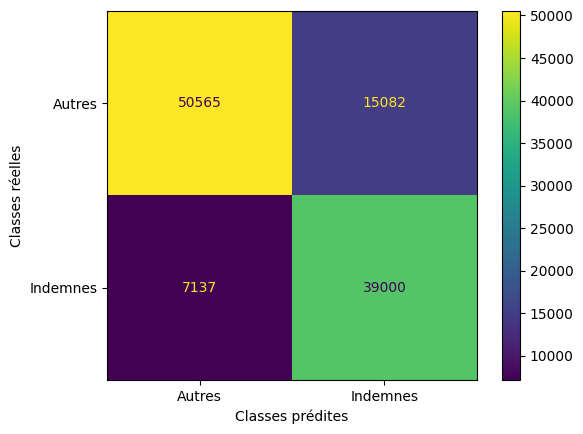

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y__test_pred)
disp = ConfusionMatrixDisplay.from_estimator(
        rf_indemne_model,
        X_test_rf,
        y_test,
        display_labels=['Autres','Indemnes']
    )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig('../../../data/img/'+ 'rf_binaire_indemnesvsautres_confusion_matrix' + '.png')

### Feature importance

In [179]:
importances_best_model = pd.DataFrame({'feature':X_train_rf.columns,'importance':np.round(best_model.feature_importances_,3)})
importances_best_model = importances_best_model.sort_values('importance',ascending=False).set_index('feature')
importances_best_model.head(38)

,importance
feature,
eq_ceinture,0.128
place_rec,0.101
catv,0.083
obsm,0.078
col,0.064
eq_casque,0.064
lat,0.049
long,0.048
age_usager,0.047


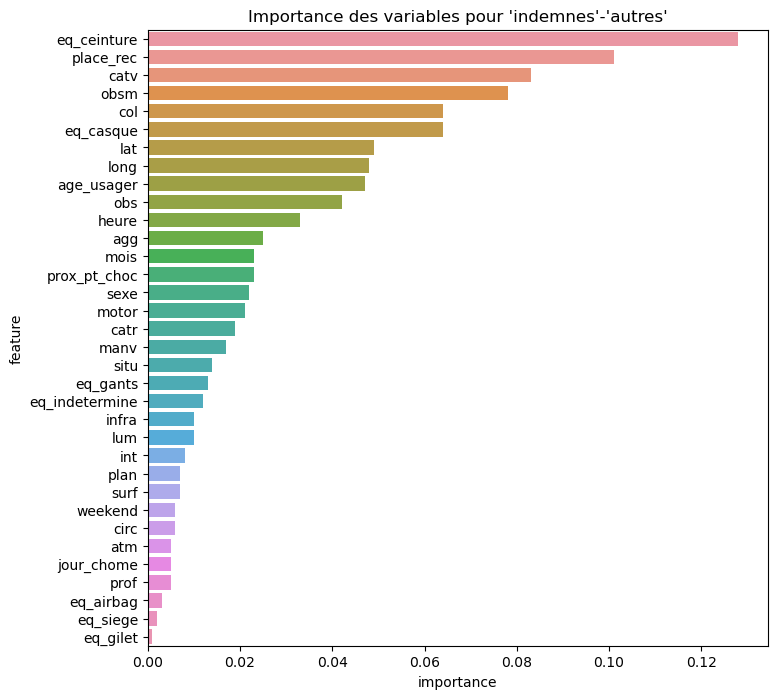

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 8))
sns.barplot(y = importances_best_model.index, x = importances_best_model['importance'])
plt.title("Importance des variables pour 'indemnes'-'autres'")
plt.show()

### Interprétation avec SHAP

In [15]:
import shap

explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test_rf)

print('Expected Value:', explainer.expected_value)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Expected Value: [0.49993525 0.50006475]


In [16]:
print(shap_values.shape)
print(type(shap_values))
print(shap_values[0].shape)
print(shap_values[1].shape)

(111784, 34, 2)
<class 'numpy.ndarray'>
(34, 2)
(34, 2)


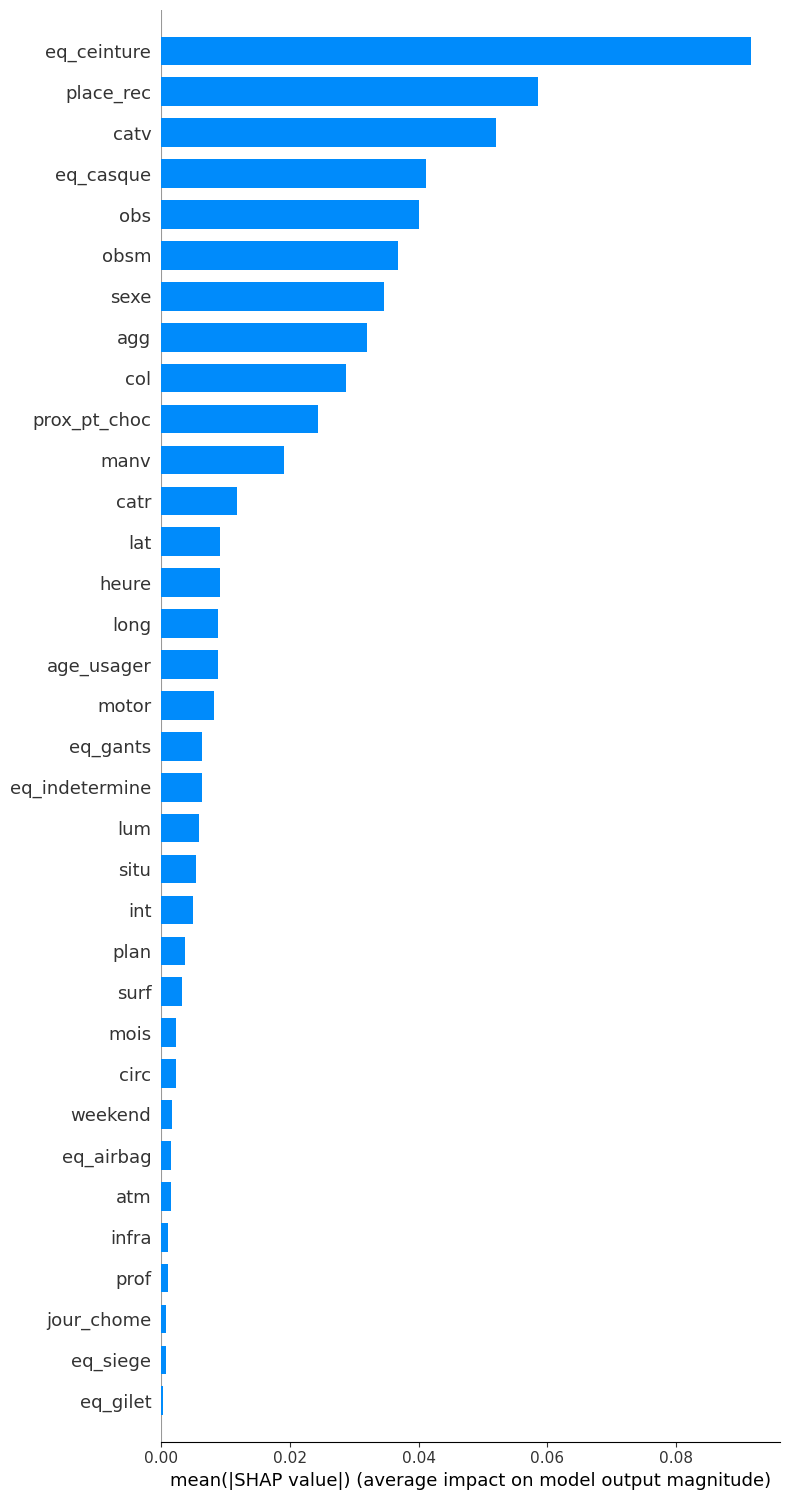

In [17]:
# Pour la classe 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

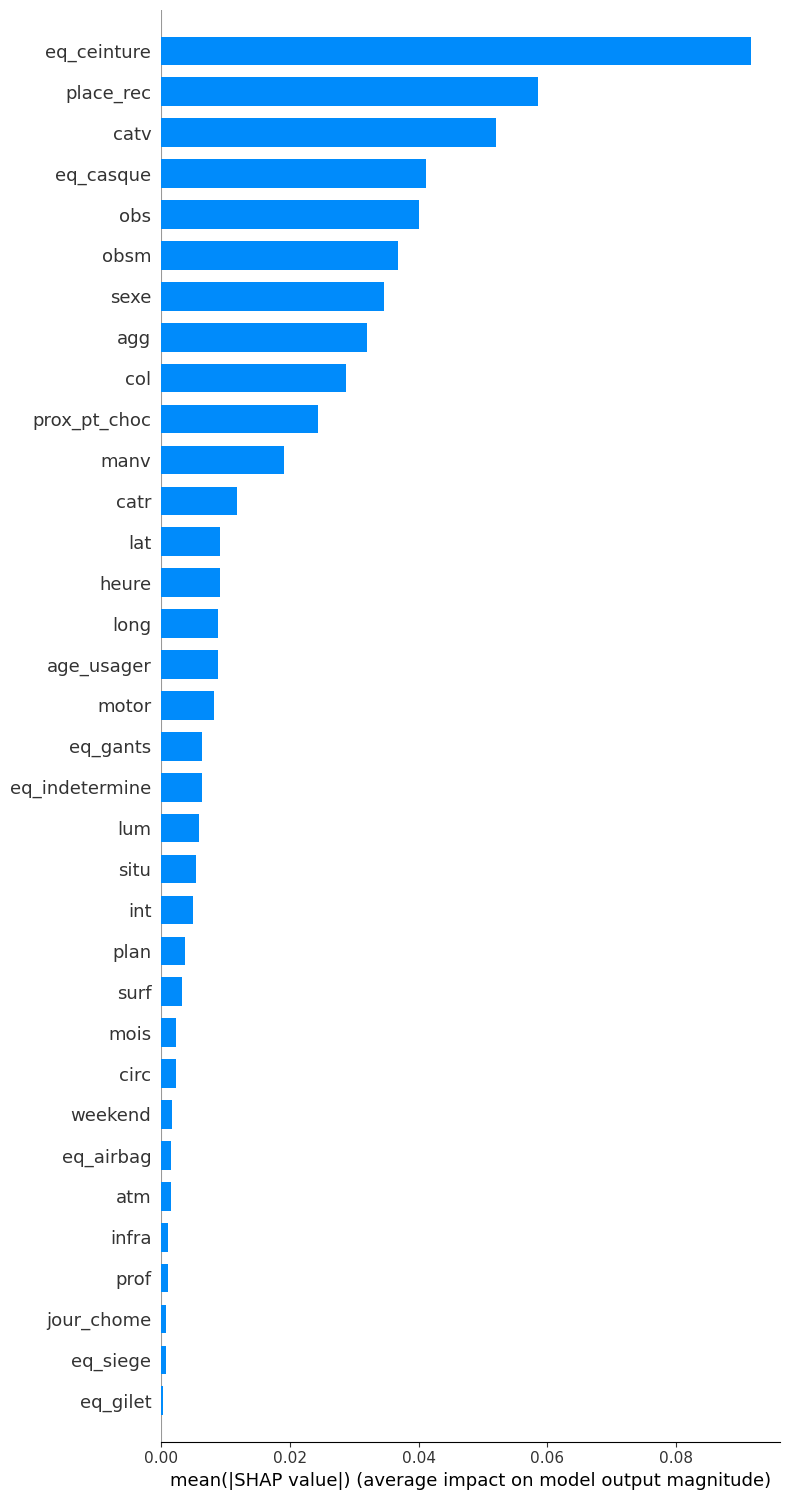

In [18]:
# Pour la classe 'indemnes'
shap.summary_plot(shap_values[:, :, 1], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

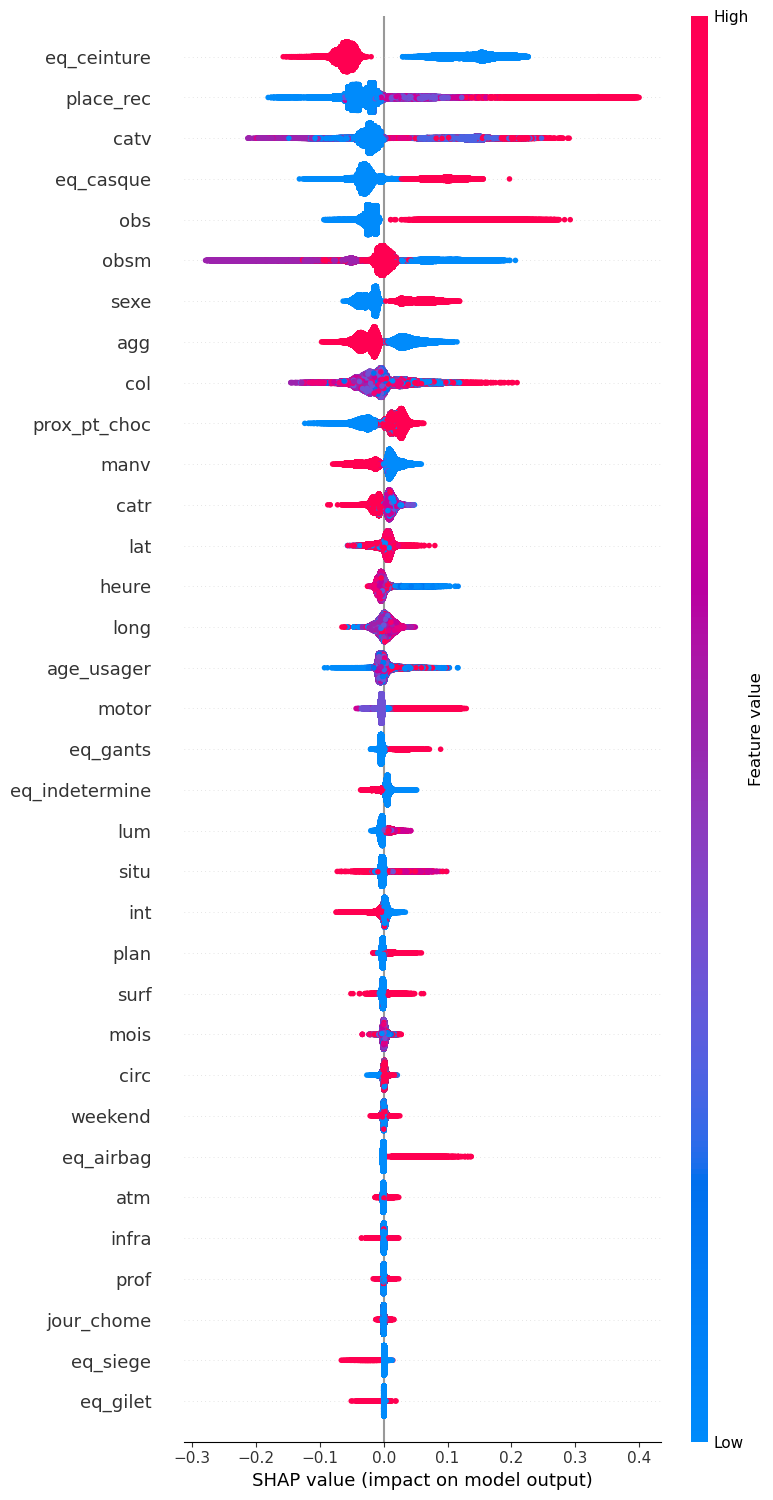

In [21]:
# Pour les 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf, max_display = len(X_test_rf))

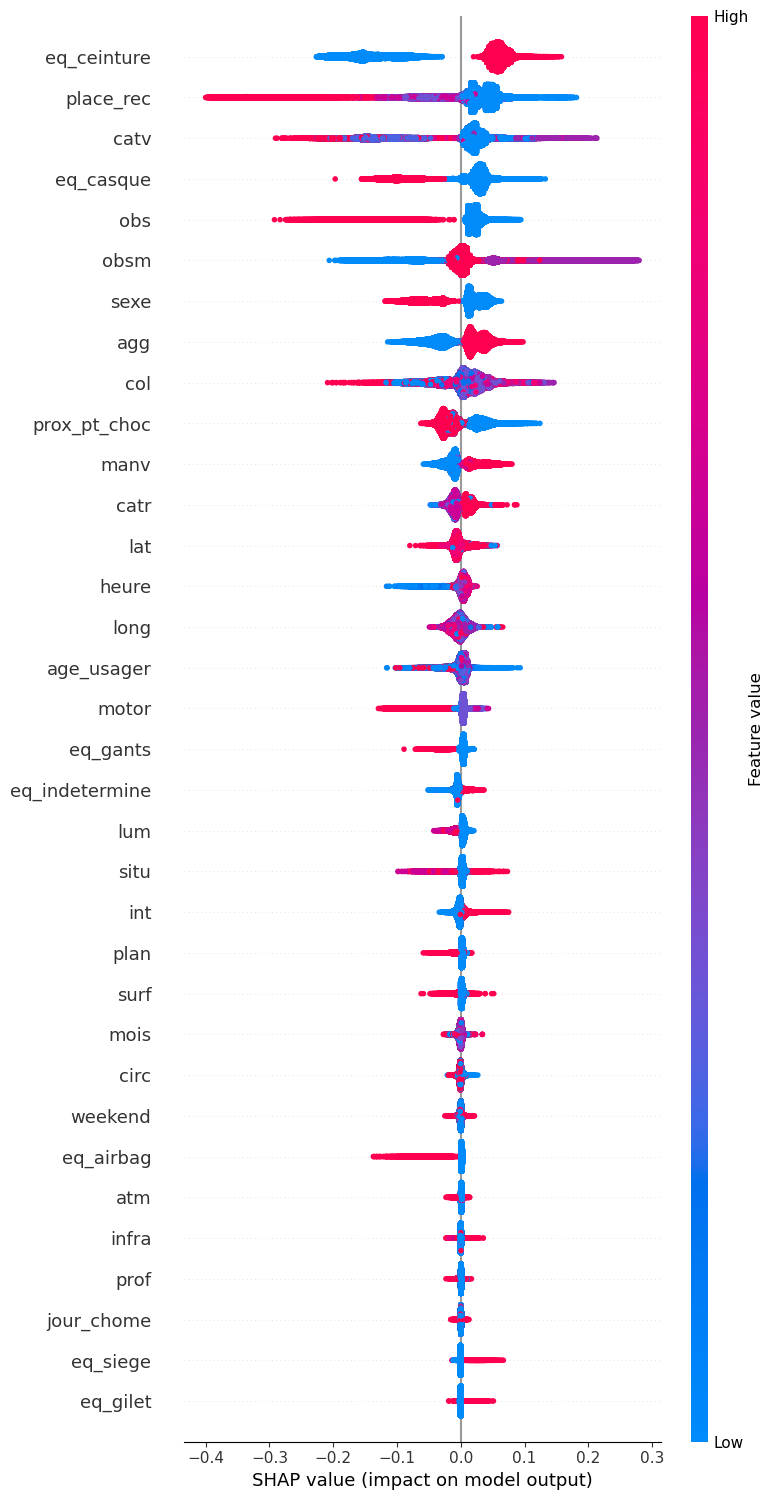

In [22]:
# Pour les 'indemnes'
shap.summary_plot(shap_values[:, :, 1], X_test_rf, max_display = len(X_test_rf))

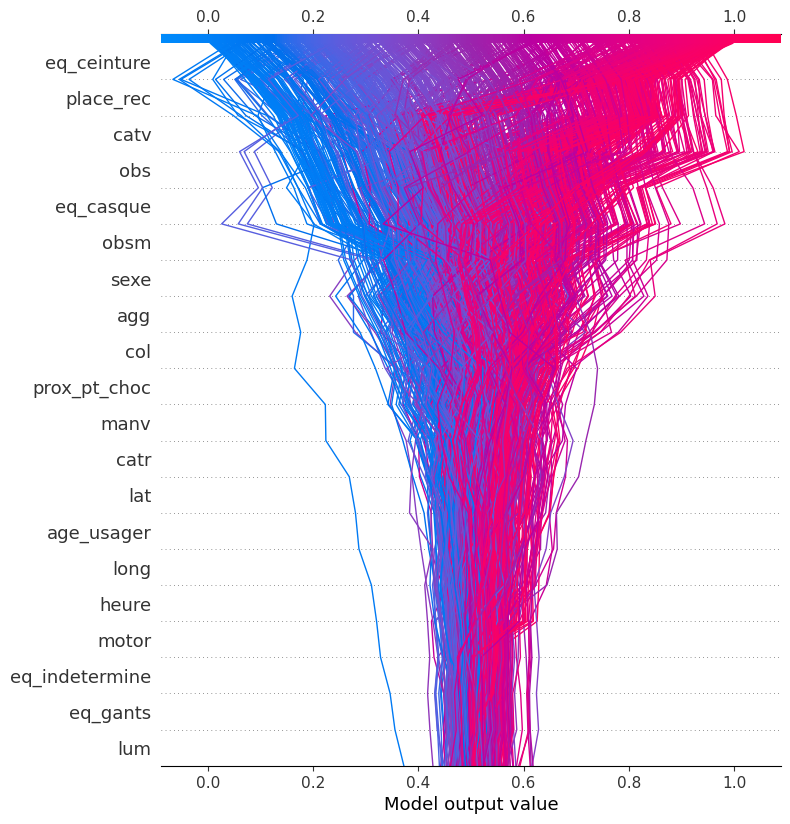

In [188]:
# détermination des variables qui contribuent au label '0'
shap.decision_plot(explainer.expected_value[0], shap_values[0:1000, :, 0], X_test_rf.columns)

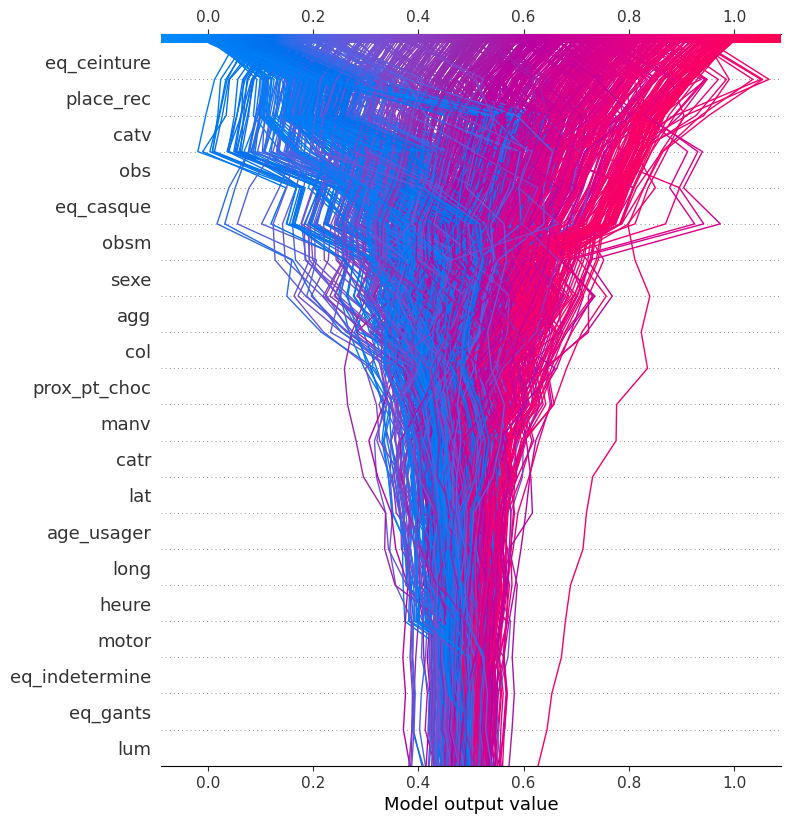

In [189]:
# détermination des variables qui contribuent au label '1'
shap.decision_plot(explainer.expected_value[1], shap_values[0:1000, :, 1], X_test_rf.columns)

# Améliorations du modèle avec monotonic_cts

In [11]:
weight = pd.DataFrame(X_test_rf.columns, columns = ['features'])
weight['weight'] = 0

In [16]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[i]= mono
        
        best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = 'balanced', 
                                    criterion = 'entropy', 
                                    max_depth = 20, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 10, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
        y_train_pred = best_model.predict(X_train_rf)
        y_test_pred = best_model.predict(X_test_rf)
        
        train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
        test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
        f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
        f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
        index_list.append(i)
        features_list.append(weight.loc[i]['features'])
        weight_list.append(mono)
        train_accuracy_list.append(train_accuray)
        test_accuracy_list.append(test_accuracy)
        f1_score_0_list.append(f1_scores[0])
        f1_score_1_list.append(f1_scores[1])
        f1_macro_list.append(f1_macros)

In [17]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 77.0].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
64,32,eq_gilet,-1,85.41,80.12,81.99,77.83,79.91
55,27,surf,1,85.27,80.11,82.01,77.76,79.89
43,21,eq_gants,1,85.56,80.09,81.94,77.82,79.88
61,30,atm,1,85.32,80.10,82.00,77.76,79.88
21,10,eq_casque,1,85.68,80.09,81.97,77.76,79.87
63,31,eq_airbag,1,85.43,80.08,81.95,77.78,79.87
65,32,eq_gilet,1,85.51,80.08,81.97,77.75,79.86
67,33,eq_siege,1,85.38,80.07,81.98,77.72,79.85
41,20,eq_indetermine,1,85.25,80.07,81.94,77.77,79.85
49,24,prof,1,85.35,80.07,81.95,77.75,79.85


In [18]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []
j = 32

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[j] = -1
        if (i != j):
            weight["weight"].values[i]= mono
        
            best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = 'balanced', 
                                    criterion = 'entropy', 
                                    max_depth = 20, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 10, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
            y_train_pred = best_model.predict(X_train_rf)
            y_test_pred = best_model.predict(X_test_rf)
        
            train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
            test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
            f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
            f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
            index_list.append(i)
            features_list.append(weight.loc[i]['features'])
            weight_list.append(mono)
            train_accuracy_list.append(train_accuray)
            test_accuracy_list.append(test_accuracy)
            f1_score_0_list.append(f1_scores[0])
            f1_score_1_list.append(f1_scores[1])
            f1_macro_list.append(f1_macros)

In [19]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 77.0].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
63,31,eq_airbag,1,85.54,80.10,81.97,77.79,79.88
47,23,jour_chome,1,85.34,80.09,81.95,77.81,79.88
21,10,eq_casque,1,85.64,80.08,81.96,77.76,79.86
53,26,situ,1,85.50,80.08,81.99,77.72,79.85
45,22,weekend,1,85.29,80.05,81.90,77.78,79.84
31,15,motor,1,85.31,80.04,81.89,77.79,79.84
61,30,atm,1,85.34,80.05,81.91,77.77,79.84
49,24,prof,1,85.37,80.06,81.93,77.75,79.84
59,29,plan,1,85.28,80.04,81.88,77.79,79.84
43,21,eq_gants,1,85.67,80.05,81.91,77.75,79.83


On s'arrête ici pour les ajustement car le f1_macro diminue. On a ajusté la variables 'eq_gilet'

In [12]:
weight['weight'] = 0
weight["weight"].values[32] = -1

best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = 'balanced', 
                                    criterion = 'entropy', 
                                    max_depth = 20, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 10, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.41 %
Test acuracy :  80.12 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50565,15082
1,7137,39000



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.77      0.82     65647
           1       0.72      0.85      0.78     46137

    accuracy                           0.80    111784
   macro avg       0.80      0.81      0.80    111784
weighted avg       0.81      0.80      0.80    111784



In [13]:
joblib.dump(best_model, "../../../data/saved_models/RandomForest_2classes_indemnes_autres.joblib")

['../../../data/saved_models/RandomForest_2classes_indemnes_autres.joblib']

In [14]:
fich = conf['local_data_path'] + "/saved_models/RandomForest_2classes_indemnes_autres.joblib"
fich_zip = conf['local_data_path'] + "/saved_models/RandomForest_2classes_indemnes_autres.zip"
myZip = zipfile.ZipFile(fich_zip, 'w', zipfile.ZIP_DEFLATED)
myZip.write(fich)
myZip.close()